# Imports

In [1]:
import numpy as np # for np.array, .T is used for some lists while plotting.
import matplotlib.pyplot as plt # for visualizations, was very useful while debugging
from math import atan2, pi # we found that this function does not have too big of an error for sorting on angle
import json # to read the given input instances
import random

from fractions import Fraction # for exact numbers. implements most operators.

# Opening the polygon file

In [2]:
path_to_testfile = "./instances-2IMA15/instances-2IMA15/example_instance1.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/fpg-poly_0000000020_h1.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/fpg-poly_0000000020_h2.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/socg60.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/maze_79_50_05_005.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/srpg_octa_mc0000082.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/srpg_iso_aligned_mc0000088.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/srpg_iso_mc0000080.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/ccheese142.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/srpg_octa_mc0000784.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/srpg_iso_aligned_mc0001336.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/maze_4344_250_001_01.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/ccheese4390.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/fpg-poly_0000004900_h2.instance.json"
# path_to_testfile = "./instances-2IMA15/instances-2IMA15/srpg_smo_mc0005962.instance.json"


with open(path_to_testfile) as testfile:
    polygon = json.load(testfile)

In [3]:
print(polygon['type'])
print(polygon['name'])
print(polygon['n'], "points")
# print(polygon['outer_boundary'])
# print(polygon['holes'])
print(len(polygon['holes']), "holes")


CGSHOP2023_Instance
example_instance1
9 points
1 holes


### Plotting the polygon

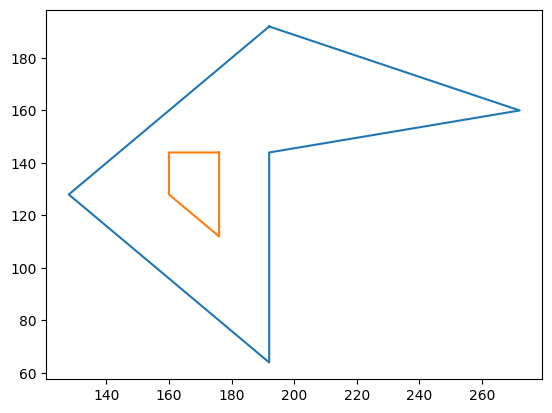

In [4]:
# function that plots the polygon and its holes
# made for easier plotting
def polygon_plt():
    listpolygon = [[polygon['outer_boundary'][-1]['x'],polygon['outer_boundary'][-1]['y']]]
    for pt in polygon['outer_boundary']:
        listpolygon.append([pt['x'], pt['y']])

    listpolygon = np.array(listpolygon)

    plt.plot(listpolygon.T[0], listpolygon.T[1])

    for hole in polygon['holes']:
        listhole = [[hole[-1]['x'], hole[-1]['y']]]
        for pt in hole:
            listhole.append([pt['x'], pt['y']])
        
        listhole = np.array(listhole)

        plt.plot(listhole.T[0], listhole.T[1])
    
polygon_plt()
plt.show()

# Polygon & helper classes

In [5]:
# A class for vertices of the polygon.
# We consider edges as directed, and store edges that have this point as its starting point in the outgoing edges, and vice versa.
# We also store its coordinates, the parent polygon (outer boundary or the specific hole).
class Point:
    def __init__(self, x, y, parent = None, incoming = [], outgoing = []):
        self.coordinate = (x,y)
        self.parent = parent
        self.incoming = incoming
        self.outgoing = outgoing

# NOT USED
# In case we still want a point class with only 1 list we can use this
# class Point1List:
#     def __init__(self, x, y, parent, adjacent):
#         self.coordinate = (x,y)
#         self.parent = parent
#         self.adjacent = adjacent
        
# A class to represent the edges of the polygon.
# pt1 is the source point of the edge, and pt2 is the target.
# We also store the parent polygon.
# The edges inserted by our algorithm are half-edges, so we have the option to set a twin.
# This is to make obtaining the convex polygons at the end easier.
class Edge:
    def __init__(self, pt1: Point, pt2: Point, parent = None):
        self.pt1 = pt1
        self.pt2 = pt2
        self.parent = parent
        self.twin = None
    
    def settwin(self, edge):
        self.twin = edge

# A class to represent the polygon.
# It stores the points that make up its outer boundary in counter-clockwise order.
# Additionally, the edges of the outer boundary are stored in counter-clockwise order.
# Finally, we have the option to set the holes of this polygon.
# Holes should be Polygon objects, with their points list in clockwise order.
class Polygon:
    def __init__(self, isHole, points: list[Point], edges: list[Edge], holes: list):
        self.isHole = isHole #not really utilized
        self.points = points
        self.edges = edges
        self.holes = holes

    def setholes(self, holes_new):
        self.holes = holes_new


### Turning polygon dictionary from file into Polygon class

In [6]:
#Creating outer boundary pts, edges, polygon
listpts = []
listpolygons = []
listedges = []
alledges = []
#allpoints = []

#Create points + Edges
for pt in polygon['outer_boundary']:
    (x,y) = [pt['x'], pt['y']]
    #p = Point1List(x,y, None, [])
    p = Point(x,y, None, [], [])
    #print(p.coordinate[0], p.coordinate[1])
    listpts.append(p)

counter = 0
for pt in listpts:
    e = Edge(listpts[counter-1], listpts[counter], None)
    listedges.append(e)
    alledges.append(e)
    counter +=1

#Update adjacent edges
z = len(listpts)
for i in range(z):
    #listpts[i].adjacent.append(listedges[i-1])
    listpts[i].incoming.append(listedges[i])
    if i < z-1:
        #listpts[i].adjacent.append(listedges[i+1])
        listpts[i].outgoing.append(listedges[i+1])
    else:
        listpts[i].outgoing.append(listedges[0])
        #listpts[i].adjacent.append(listedges[0])

#allpoints = listpts

#Create polygon and update parent of points/vertices to be this polygon
poly = Polygon(0, listpts, listedges, [])
for edges in poly.edges:
    edges.parent = poly #Update edges parent
for pts in poly.points:
    pts.parent = poly #Update point parent

#Print checks to get items
#for element in poly.points:
#    print(element.coordinate, element.parent, (element.incoming[0].pt1, element.incoming[0].pt2), (element.outgoing[0].pt1, element.outgoing[0].pt2))

print("Basic (Outside) polygon has now", len(poly.edges), "Edges and", len(poly.points), "Points")


Basic (Outside) polygon has now 5 Edges and 5 Points


In [7]:
#Do the same for holes
counter = 0
if len(polygon['holes']) == 0:
    ishole = 0
else:
    ishole = 1

#If we have holes, we are allowed to do this part    
if ishole:

    length_holes = len(polygon['holes'])
    listholepolygons = []
    
    #We might get multiple holes, so 1 list per hole for the edges and points of a hole
    for ctr in range(length_holes):
        listholeedges = []
        listholepts = []
        
        #Points in hole
        length = len(polygon['holes'][ctr])
        for n in range(length):
            (xh,yh) = (polygon['holes'][ctr][n]['x'], polygon['holes'][ctr][n]['y'])
            #print((xh,yh))
            #p = Point1List(xh,yh, None, [])
            p = Point(xh,yh, None, [], [])
            listholepts.append(p)
        
        #Edges in hole
        counter = 0
        for pt in listholepts:
            e = Edge(listholepts[counter-1], listholepts[counter], None)
            #print("EDGE Added:", e.pt1, e.pt2)
            listholeedges.append(e)
            alledges.append(e)
            counter +=1

        #adjacent edges of a point
        z = len(listholepts)
        for i in range(z):
            #listholepts[i].adjacent.append(listholeedges[i])
            listholepts[i].incoming.append(listholeedges[i])
            if i < z-1:
                #listholepts[i].adjacent.append(listholeedges[i+1])
                listholepts[i].outgoing.append(listholeedges[i+1])
            else:
                listholepts[i].outgoing.append(listholeedges[0])
                #listholepts[i].adjacent.append(listedges[0])
              
        counter = 0
        h = Polygon(1, listholepts, listholeedges, [])
        #Update all edges and points to make sure that the parent is set to this hole
        for edges in h.edges:
            edges.parent = h #Update edges parent
        for pts in h.points:
            pts.parent = h #Update point parent
            #allpoints.append(pts)

        #append hole to list
        listholepolygons.append(h)
        
    #add all holes we created in the main polygon
    poly.setholes(listholepolygons)
    #print(len(poly.holes))

    print("Updated (Outside + Holes) polygon has now", len(poly.edges), "Edges and", len(poly.points), "Points, Including", len(poly.holes), "Holes")
    #for element in poly.points:
    #    print(element.coordinate, element.parent, (element.incoming[0].pt1, element.incoming[0].pt2), (element.outgoing[0].pt1, element.outgoing[0].pt2))
    # for holex in poly.holes:
    #     for pt in holex.points:
    #         print(pt.coordinate)
    #for elem in range(len(alledges)):
    #    print(alledges[elem].pt1, alledges[elem].pt2)

Updated (Outside + Holes) polygon has now 5 Edges and 5 Points, Including 1 Holes


### Class plotting functions

In [8]:
def edge_plt(e: Edge, scatter=True):
    xs = [e.pt1.coordinate[0], e.pt2.coordinate[0]]
    ys = [e.pt1.coordinate[1], e.pt2.coordinate[1]]
    plt.plot(xs, ys, c='black')
    if scatter: plt.scatter(xs[1:], ys[1:], c='black')

In [9]:
def pt_plot(pts: list[Point]):
    for pt in pts:
        plt.scatter([pt.coordinate[0]], [pt.coordinate[1]])

# Useful functions

Functions definitions that are used throughout this document

### Orientation

In [10]:
# Returns the orientation of p3 w.r.t. the (directed) line through p1 and p2
# If the result is 1, p3 lies to the left, if it is -1 it lies to the right, and if it is 0 p3 lies on the line.
def orientation_class(p1: Point, p2: Point, p3: Point):

    #vector from p1 to p2
    a = [p2.coordinate[0] - p1.coordinate[0], p2.coordinate[1] - p1.coordinate[1]]
    #vector from p1 to p3
    b = [p3.coordinate[0] - p1.coordinate[0], p3.coordinate[1] - p1.coordinate[1]]

    #cross product
    cross = a[0] * b[1] - a[1] * b[0]

    if cross == 0: #colinear
        return 0, cross
    else: #sign gives left or right of \bar{p1p2}
        return np.sign(cross), cross

##### Obsolete variants

In [11]:
#returns the orientation of p3 wrt line through p1 and p2
def orientation(p1, p2, p3):

    #vector from p1 to p2
    a = [(p2['x'] - p1['x']), (p2['y'] - p1['y'])]
    #vector from p1 to p3
    b = [(p3['x'] - p1['x']), (p3['y'] - p1['y'])]

    #cross product
    cross = a[0] * b[1] - a[1] * b[0]

    if cross == 0: #colinear
        return 0
    else: #sign gives left or right of \bar{p1p2}
        return np.sign(cross)

In [12]:
#returns the orientation as sign and its exact value (needed for sorting) of p3 wrt line through p1 and p2 using the coordinates only
def orientation_coordinates(p1, p2, p3):
    #vector from p1 to p2
    a = [(p2[0] - p1[0]), (p2[1] - p1[1])]
    #vector from p1 to p3
    b = [(p3[0] - p1[0]), (p3[1] - p1[1])]

    #cross product
    cross = a[0] * b[1] - a[1] * b[0]
    val = cross

    if cross == 0: #colinear
        return 0, val
    else: #sign gives left or right of \bar{p1p2} and the exact value
        return np.sign(cross), val

### Finding reflex vertices

In [13]:
# This function finds all reflex vertices in the polygon and its holes.
# It also returns the number of reflex vertices and a list containing all the points.
def find_reflex_in_class(polygon: Polygon):
    bdry = polygon.points
    holes = polygon.holes
    count = 0
    reflex = []
    allpts = []

    for i in range(len(bdry)):
        if orientation_class(bdry[(i-1)], bdry[i], bdry[(i+1) % len(bdry)])[0] == -1: # a right turn means i is reflex
            reflex.append(bdry[i]); count += 1
        allpts.append(bdry[i])
    
    # print("We found", len(reflex), "Reflex points in our outer boundary of the polygon")
    for hole in holes:
        for i in range(len(hole.points)):
            if orientation_class(hole.points[(i-1)], hole.points[i], hole.points[(i+1) % len(hole.points)])[0] == -1: 
                reflex.append(hole.points[i]); count += 1
            allpts.append(hole.points[i])

    return reflex, count, allpts

refl, nr, all = find_reflex_in_class(poly)
# print("We found", nr, "reflex vertices in the polygon (including its holes)")
#for i in refl:
#    print(i.coordinate, i.incoming[0].pt1, i.incoming[0].pt2, i.outgoing[0].pt1, i.outgoing[0].pt2)

##### Obsolete variant

In [14]:
def find_reflex(polygon):
    n = polygon['n']
    bdry = polygon['outer_boundary']
    holes = polygon['holes']
    count = 0
    reflex = []

    for i in range(len(bdry)):
        if orientation(bdry[(i-1)], bdry[i], bdry[(i+1) % len(bdry)]) == -1: reflex.append(bdry[i]); count += 1

    for hole in holes:
        for i in range(len(hole)):
            if orientation(hole[(i-1)], hole[i], hole[(i+1) % len(hole)]) == -1: reflex.append(hole[i]); count += 1

    return reflex, count

##### Plotting reflex vertices 

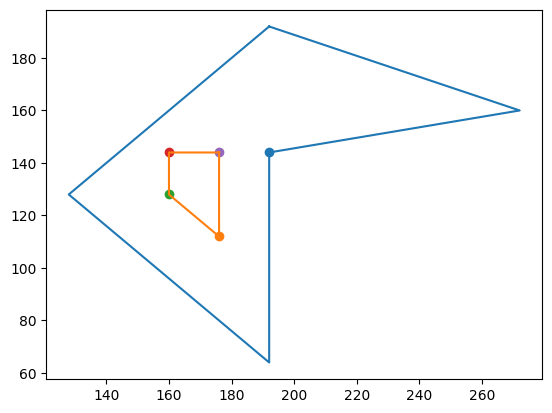

In [15]:
polygon_plt()
pt_plot(refl)

### Computing the intersection point of two lines exactly

The idea is as follows.
```
y = m1 x + b1 -> m1 x + b1 - y = 0
y = m2 x + b2 -> m2 x + b2 - y = 0

->
m1 x + b1 = m2 x + b2
->
x* = (b2-b1) / (m1-m2)
y* = m1 x* + b1
```

In [16]:
# Computes the intersection point (IP) of two lines each defined by two Points
# Achieved with line equations, and many special cases for edge cases
def intersection_point(l1: Edge, l2: Edge) -> Point:
    dy1 = l1.pt2.coordinate[1] - l1.pt1.coordinate[1]
    dx1 = l1.pt2.coordinate[0] - l1.pt1.coordinate[0]
    # slope1 = dy1 / dx1

    dy2 = l2.pt2.coordinate[1] - l2.pt1.coordinate[1]
    dx2 = l2.pt2.coordinate[0] - l2.pt1.coordinate[0]
    # slope2 = dy2 / dx2

    xnum,xden,ynum,yden = [-1]*4 #init vars

    if dx1 == 0 and dx2 != 0: #line 1 is vertical, fill in its x in line 2 equation
        xnum = l1.pt1.coordinate[0]
        xden = 1

        pt4 = l2.pt2
        
        b2num = pt4.coordinate[1] * dx2 - pt4.coordinate[0] * dy2
        b2den = dx2

        ynum = dy2 * xnum + b2num * xden
        yden = dx2 * xden

    elif dx2 == 0 and dx1 != 0: #line 2 is vertical
        xnum = l2.pt1.coordinate[0]
        xden = 1

        pt2 = l1.pt2
        b1num = pt2.coordinate[1] * dx1 - pt2.coordinate[0] * dy1
        b1den = dx1

        ynum = dy1 * xnum + b1num * xden
        yden = dx1 * xden

    elif dx1 == 0 and dx2 == 0: #parallel or colinear
        if l1.pt1.coordinate[0] != l2.pt1.coordinate[0]:
            return None
        
        y1 = l1.pt1.coordinate[1]
        return l2.pt1 if abs(l2.pt1.coordinate[1] - y1) <= abs(l2.pt2.coordinate[1] - y1) else l2.pt2
    else:
        # points on the lines that will be used to find intercepts
        pt2 = l1.pt2
        pt4 = l2.pt2

        # y-intercepts
        b1num = pt2.coordinate[1] * dx1 - pt2.coordinate[0] * dy1
        b1den = dx1

        b2num = pt4.coordinate[1] * dx2 - pt4.coordinate[0] * dy2
        b2den = dx2

        if dy1 == 0 and dy2 == 0: #both horizontal, same as vertical
            if l1.pt1.coordinate[1] != l2.pt1.coordinate[1]:
                return None
            
            x1 = l1.pt1.coordinate[0]
            return l2.pt1 if abs(l2.pt1.coordinate[0] - x1) <= (l2.pt2.coordinate[0] - x1) else l2.pt2

        elif dy1 == 0 and dy2 != 0: #l1 horizontal
            y1 = l1.pt1.coordinate[1]
            
            xnum = y1 - Fraction(b2num, b2den)
            xden = Fraction(dy2, dx2)

            ynum = dy2 * xnum + b2num * xden
            yden = dx2 * xden
        elif dy2 == 0 and dy1 != 0: #l2 horizontal
            y2 = l2.pt1.coordinate[1]
            
            xnum = y2 - Fraction(b1num, b1den)
            xden = Fraction(dy1, dx1)

            ynum = dy1 * xnum + b1num * xden
            yden = dx1 * xden
        else:
            # the x-coordinate of the intersection point
            xnum = (b2num * b1den - b1num * b2den)
            xden = dy1 * dx2 - dy2 * dx1

            # the y-coordinate of the intersection point
            ynum = dy1 * xnum + b1num * xden
            yden = dx1 * xden

    return Point(Fraction(xnum, xden), Fraction(ynum, yden), None, [], [])

### Miscellaneous

In [17]:
# A function that computes the angle between three points
# The angle is measured at p2, and only the angle on the left side of the edge p1p2 and p2p3 is returned.
# Using atan2 works well enough to do radial sorting.
def angle(p1: Point, p2: Point, p3: Point):
    Ax, Ay = p3.coordinate[0] - p2.coordinate[0], p3.coordinate[1] - p2.coordinate[1]
    Cx, Cy = p1.coordinate[0] - p2.coordinate[0], p1.coordinate[1] - p2.coordinate[1]

    a = atan2(Ay, Ax)
    c = atan2(Cy, Cx)
    if a < 0: a += pi*2
    if c < 0: c += pi*2
    return (pi*2 + c - a) if a > c else (c - a) 

In [18]:
# Returns the squared distance between two points.
# This is used to sort the distance of intersection points, so the actual distance is not necessary.
def dist(p: Point, q: Point):
    return ((p.coordinate[0] - q.coordinate[0])**2 + (p.coordinate[1] - q.coordinate[1])**2)#**Fraction(1,2))

In [19]:
# A function that checks whether two points have the same coordinate.
def pointequals(p1: Point, p2: Point) -> bool:
    return p1.coordinate[0] == p2.coordinate[0] and p1.coordinate[1] == p2.coordinate[1]

In [20]:
# A function that given an edge and a point on that edge, the other point that defines the edge.
# The case where p does not lie on the edge is not handled and we trust our code to call this function correctly.
def other(e: Edge, p: Point) -> Point:
    return e.pt1 if pointequals(p, e.pt2) else e.pt2

# Sweep algorithm

This is how far we got while attempting to implement a sweep algorithm.

### Event handling

In [21]:
# There is only one type of event.
# We need to remove edges that "end" (not in terms of the direction of the edge, but the sweep)
# in this Point from the status, and add the edges that "start" here.
# We want to report the Points of the polygon that are endpoints of an edge that is visible to r
def handle_event(p: Point, r: Point, status):
    d = dist(p,r) #is it needed?

    # print(status)
    reportThis = False
    
    toBeAdded = []

    edges, dists = zip(*status) # list of pairs (edge, dist) to two lists of edges and dists
    edges = list(edges)

    if (pointequals(edges[0].pt1, p) or pointequals(edges[0].pt2, p)):
        reportThis = True

    for edge in (p.incoming + p.outgoing): # all edges ending or starting here
        try:
            idx = edges.index(edge) #finds the index of 'edge' in 'edges' if it exists, may throw error

            del edges[idx]
            del status[idx]
        except: #edge is not in edges of the status, so we must add it to the status
            toBeAdded.append([edge, d]) #can we just append with 0, since we calc after anyway?
    
    # recompute distances of intersection point with sweepline and edges in the status
    for i in range(len(status)):
        isectpt = intersection_point( Edge(r, p, None), status[i][0] ) #intersect rp with status[i][0]
        status[i][1] = dist(r, isectpt) #replace distance with correct value for current event

    
    toBeAdded.sort(key=lambda ed : angle(r, p, other(ed[0], p)))

    status.extend(toBeAdded)
    
    # sort the status on the distance of the intersection point of the sweepline to the edge
    status.sort(key=lambda e : e[1])

    reportThis |= (pointequals(status[0][0].pt1, p) or pointequals(status[0][0].pt2, p))
    
    # if p is an endpoint of the edge currently visible to r, we need to report it.
    return status, reportThis

### Feasible region

In [22]:
# Ideally this computes the vertices of the polygon that are visible to r.
def feasible_region(r: Point, polygon: Polygon):
    
    '''EVENT QUEUE INITIALIZATION'''
    #Add all points of polygon outer boundary and holes together to loop over all points to decide with orientation test which are in region of sweep
    allpoints = []
    for element in poly.points:
        allpoints.append(element)
    for elements in poly.holes:
        for pts in elements.points:
            allpoints.append(pts)

    in_queue_of_reflex = []
    for ap in allpoints:
        if pointequals(ap, r):
            continue

        res = orientation_class(r.incoming[0].pt1, r, ap)
        res2 = orientation_class(r, r.outgoing[0].pt2, ap)

        if (res[0] >= 0 and res2[0] >= 0):
            in_queue_of_reflex.append(ap) #only if the point is inside the "wedge" of the extended incoming and outgoing edges it is in the eventqueue
    in_queue_of_reflex.sort(reverse = True, key=lambda v: angle(r.incoming[0].pt1, r, v)) #We sort all v's on the angle of the edge incoming to r and v

    SORTED_EVENT_QUEUE = in_queue_of_reflex

    # print("EVENT QUEUE SIZE: ", len(SORTED_EVENT_QUEUE))

    '''STATUS INITIALIZATION'''
    incoming = r.incoming[0]

    edges = [] #all edges currently in the polygon (including inserted half-edges)

    for pt in poly.points:
        for edge in pt.outgoing:
            if edge in (r.incoming + r.outgoing):
                continue
            edges.append(edge)

    for hole in poly.holes:
        for pt in hole.points:
            for edge in pt.outgoing:
                if edge in (r.incoming + r.outgoing):
                    continue
                edges.append(edge)

    STATUS = [] # the status structure
    
    for edge in edges:
        #init status: edges that intersect incoming edge supporting half-line starting in r, away from incoming
        if orientation_class(incoming.pt1, r, edge.pt1)[0] * orientation_class(incoming.pt1, r, edge.pt2)[0] < 0:
            ip = intersection_point(incoming, edge)

            if ip is None: continue

            #now check whether the intersection point is actually in the wedge.
            #make the vector that is the incoming vector rotated 90 degrees to the right.
            #add it to r to obtain s, and check whether the intersection point is left of rs.

            #v = r - incoming.pt1
            v = ((r.coordinate[0] - incoming.pt1.coordinate[0]), (r.coordinate[1] - incoming.pt1.coordinate[1]))

            #vR = (v.y, -v.x)
            vR = (v[1], -v[0])

            #s = r + vR
            s = Point((r.coordinate[0] + vR[0]), (r.coordinate[1] + vR[1]), *[None]*3)

            #if orientation ( r, s, ip ) == 1
            if orientation_class(r, s, ip)[0] < 1:
                continue

            d = dist(r, ip) #compute squared distance of intersection point
            STATUS.append([edge, d])
    
    STATUS.sort(key=lambda e : e[1])

    # print("INITIAL STATUS LENGTH: ", len(STATUS))

    '''EXECUTING THE SWEEP'''
    report = []

    STATUS_OVER_TIME = []

    for pt in SORTED_EVENT_QUEUE:
        STATUS_OVER_TIME.append(STATUS.copy())
        STATUS, report_pt = handle_event(pt, r, STATUS)
        if report_pt: report.append(pt)
    
    STATUS_OVER_TIME.append(STATUS.copy())

    return report, STATUS_OVER_TIME

In [23]:
# reflex = refl[2]
# FR, stat_at = feasible_region(reflex, poly)
# print(len(FR))

In [24]:
# for i in range(len(refl)):
#     print(f"i: {i}")
#     feasible_region(refl[i], poly)

# Adding Edges

Since this chapter was meant to be used in conjunction with the feasible region, this chapter is not used.

In [25]:
#the list of edges added by our algorithm
newedges = []

In [26]:
def find_point_in_list(pt):
    idx = None
    #print("To Find:", pt, pt.coordinate)
    #print("---------------------------------------")
    #for pts in poly.points:
    #    print(pts, pts.coordinate)
    #print("---------------------------------------")
    #for h in poly.holes:
        #for p in h.points:
    #        print(p, p.coordinate)
    #    print("---------------------------------------")
    #print("---------------------------------------")

    try:
        #print(poly.points.index(pt))
        idx= poly.points.index(pt)
    except:
        pass
        #print("Point not in poly.points")

    for i in range(len(poly.holes)):
        try:
            #print(poly.holes[i].points.index(pt))
            idx=poly.holes[i].points.index(pt),i
        except:
            pass
            #print("Point not in poly.holes[",i,"].points")
    #for holex in poly.holes:
    #    print(holex.points.index(pt))
    #print("----------END LOOP TRIAL-------------")
    if idx == None:
        print("OOPS, point:", pt, "Wasn't found in our list")
    return idx

#ptxx = Point(2,3,None,[], [])
#find_point_in_list(refl[1])
#For each edge to add we need to retrieve the 2 involved points, set the 2 edges correctly for both points and the polygon is updated

In [27]:
def find_points_in_list_and_add_edges_between_them(pta, ptb):
    #print("Edges before:")
    #print(len(poly.edges))
    #print(len(poly.holes[0].edges))
    #print(len(poly.holes[1].edges))

    pt = pta
    loc_a = None
    in_main_poly = False
    idx = find_point_in_list(pt)
    tuple_checker = isinstance(idx, tuple)
    #print(tuple_checker)
    if tuple_checker == False:
        #print(poly.points[idx])
        loc_a = poly.points[idx]
        in_main_poly = True
    else:
        #print(idx, idx[0], idx[1])
        #print(poly.holes[idx[1]].points[idx[0]])
        loc_a = poly.holes[idx[1]].points[idx[0]]

    #pt2 = refl[8]
    pt2 = ptb
    loc_b = None
    in_main_poly2 = False
    idx2 = find_point_in_list(pt2)
    tuple_checker2 = isinstance(idx2, tuple)
    #print(tuple_checker2)
    if tuple_checker2 == False:
        #print(poly.points[idx2])
        loc_b = poly.points[idx2]
        in_main_poly2 = True
    else:
        #print(idx2, idx2[0], idx2[1])
        #print(poly.holes[idx2[1]].points[idx2[0]])
        loc_b = poly.holes[idx2[1]].points[idx2[0]]
    
    #Creating the edges
    edge1 = Edge(loc_a, loc_b, None)
    edge2 = Edge(loc_b, loc_a, None)
    edge1.settwin(edge2)
    edge2.settwin(edge1)
    #Printing edge info
    #print(edge1, edge1.pt1, edge1.pt2, edge1.parent)
    #print(edge2, edge2.pt1, edge2.pt2, edge2.parent)
    #Adding the edges to the points' incoming and outgoing list
    #print(loc_a.incoming)
    loc_a.outgoing.append(edge1)
    loc_a.incoming.append(edge2)
    loc_b.incoming.append(edge1)
    loc_b.outgoing.append(edge2)
    #print(loc_a.incoming)

    #Adding the edges to where the edge.pt1 belongs to, if we don't need this, skip this, but I guess we would need it
    newedges.append([edge1, edge2])
    #newedges.append(edge2)
    #if in_main_poly == True:
    #    poly.edges.append(edge1)
        #print(len(poly.edges), poly.edges)
    #else:
    #    poly.holes[idx[1]].edges.append(edge1)
        #print(len(poly.holes[idx[1]].edges), poly.holes[idx[1]].edges)
    
    #if in_main_poly2 == True:
    #    poly.edges.append(edge2)
        #print(len(poly.edges),poly.edges)
    #else:
    #    poly.holes[idx[1]].edges.append(edge2)
        #print(len(poly.holes[idx[1]].edges), poly.holes[idx[1]].edges)

    #print("Edges After:")
    #print(len(newedges))
    #print(len(poly.edges))
    #print(len(poly.holes[0].edges))
    #print(len(poly.holes[1].edges))

#find_points_in_list_and_add_edges_between_them(refl[13], refl[1])

In [28]:
'''improved version in next chapter'''
# def insert_point_on_visible_edge(r: Point, e: Edge, polygon: Polygon):

#     #find a point on the visible edge
#     inc = r.incoming[0]

#     ip = intersection_point(inc, e)
#     if ip is None: raise ValueError("Edge was not visible; parallel")

#     ip = Point(ip.coordinate[0], ip.coordinate[1], e.parent, ip.incoming, ip.outgoing)

#     # e is an edge that we previously created
#     if e.parent is None:
#         try:
#             newedges.remove([e,e.twin])
#         except:
#             newedges.remove([e.twin,e])

#         e.pt1.outgoing.remove(e)
#         e.pt2.incoming.remove(e)

#         e.twin.pt1.outgoing.remove(e.twin)
#         e.twin.pt2.incoming.remove(e.twin)

#         #create edges
#         #replacing old edge e
#         split1 = Edge(e.pt1, ip, None)
#         split2 = Edge(ip, e.pt2, None)
#         #will be added later

#         twin_split1 = Edge(ip, e.pt1, None)
#         twin_split2 = Edge(e.pt2, ip, None)

#         split1.settwin(twin_split1)
#         split2.settwin(twin_split2)
#         twin_split1.settwin(split1)
#         twin_split2.settwin(split2)

#         ip.outgoing.append(twin_split1)
#         ip.incoming.append(twin_split2)

#         e.pt1.incoming.append(twin_split1)
#         e.pt1.outgoing.append(split1)
#         e.pt2.incoming.append(split2)
#         e.pt2.outgoing.append(twin_split2)

#         newedges.extend([[split1, twin_split1], [split2, twin_split2]])

#     else: #e is part of a hole or the boundary
#         #delete edge from polygon
#         parpoly = e.parent

#         try:
#             ixe = parpoly.edges.index(e)
#             del parpoly.edges[ixe]
#         except:
#             print([(edge.pt1.coordinate, edge.pt2.coordinate) for edge in parpoly.edges])
#             print((e.pt1.coordinate, e.pt2.coordinate))

#             polygon_plt()
#             pt_plot(e.parent.points)
#             edge_plt(e)

#             raise ValueError("Edge is not in its parent somehow")

#         #insert ip into points list at the correct place
#         ix = parpoly.points.index(e.pt1)
#         parpoly.points.insert(ix, ip)

#         #create edges
#         #replacing old edge e
#         split1 = Edge(e.pt1, ip, parpoly)
#         split2 = Edge(ip, e.pt2, parpoly)

#         #set inc out for edge endpoints
#         e.pt1.outgoing.insert(0, split1)
#         e.pt2.incoming.insert(0, split2)

#         #insert split edges into polygon
#         parpoly.edges.insert(ixe, split2)
#         parpoly.edges.insert(ixe, split1)

#     #remove e from incident points edge lists
#     try:
#         e.pt1.incoming.remove(e)
#     except:
#         pass

#     try:
#         e.pt1.outgoing.remove(e)
#     except:
#         pass

#     try:
#         e.pt2.incoming.remove(e)
#     except:
#         pass

#     try:
#         e.pt2.outgoing.remove(e)
#     except:
#         pass

#     #new edges to handle r
#     new1 = Edge(r, ip, None)
#     new2 = Edge(ip, r, None)
#     new1.settwin(new2)
#     new2.settwin(new1)

#     #add new edges to the list
#     newedges.append([new1, new2])

#     #set incoming and outgoing for ip and r
#     ip.incoming.extend([split1, new1])
#     ip.outgoing.extend([split2, new2])

#     r.outgoing.append(new1)
#     r.incoming.append(new2)
    
#     return ip

'improved version in next chapter'

In [29]:
reflcopy = refl.copy()

def convexize():
    while len(refl) > 0:
        if len(refl) % 10 == 0: print(len(refl))
        reflex = refl[0]
        FR, stat_at = feasible_region(reflex, poly)

        #To Do: Implement full code for adding edges
        # print("Len refl before:", len(refl))
        # print("len newedges before:", len(newedges))
        pt = reflex #Here we can update our point in the list if we do all reflex points after each other
        # print("To Find:", pt)
        # print("In its FR:", FR)
        # print(stat)
        # print("----------------------")

        handled = False
        for item in FR:
            if item in refl:
                # print("This point is reflex!:", item)
                frp, status = feasible_region(item, poly)
                # print("FR of reflex item:", frp)
                if(pt in frp):
                    # print("YES", pt, "Sees", item, "And vice versa")
                    find_points_in_list_and_add_edges_between_them(pt, item)
                    refl.remove(item) #Remove the reflex vertex which is matched with our i
                    # print("We added edges between 2 reflex points")
                    handled = True
                    break;
                # else:
                    # print("NOT in each other's region")
            # else:
                # print("NOT Reflex")
        if handled == False and len(FR) > 0:
            # print("Bad luck, we didn't find 2 reflex vertices that saw each other")
            nr = random.randint(0, len(FR)-1)
            # print("Took randomly point from FR with index", nr, "from", len(FR), "options to connect with reflex point")
            find_points_in_list_and_add_edges_between_them(pt, FR[nr])
            
        if len(FR) == 0:
            # print("FR Was empty, so we had to create a new point and update the edges")
            # TODO: Make a new point, delete old edge, add 4 new edges
            insert_point_on_visible_edge(pt, stat_at[0][0][0], poly)


        refl.remove(pt) # Delete point "pt" from reflex list
        # print("Len refl after:", len(refl))
        # print("len newedges after:", len(newedges))

# %prun convexize()

In [30]:
# polygon_plt()

# for new in newedges:
#     xs = [new[0].pt1.coordinate[0], new[0].pt2.coordinate[0]]
#     ys = [new[0].pt1.coordinate[1], new[0].pt2.coordinate[1]]
#     plt.plot(xs, ys, c='darkred')

# pt_plot(poly.points)

# plt.show()

In [31]:
# polygon_plt()

# plt.scatter(reflex.coordinate[0], reflex.coordinate[1])

# for e,d in stat_at[0]:
#     xs = [e.pt1.coordinate[0], e.pt2.coordinate[0]]
#     ys = [e.pt1.coordinate[1], e.pt2.coordinate[1]]
#     plt.scatter(xs,ys)

# plt.show()

# Something simpler - bruteforce sweep

Since we had trouble implementing the sweep, we quickly made this to be able to report at least some solutions.

For the bigger datasets, it runs very slowly.

### Useful functions and variables for this chapter

In [32]:
#edges that we will insert
#will be a list of pairs of edges that are twins, to represent the half-edge.
newedges = []

#all edges of the polygon
alledges = []
for pt in poly.points:
    alledges.extend(pt.outgoing)
for hole in poly.holes:
    for pt in hole.points:
        alledges.extend(pt.outgoing)

In [33]:
# A function that returns the next edge for an edge.
# A next edge is the edge that is not its twin and makes the sharpest turn (on its left side).
def next(e: Edge):
    outs = sorted(e.pt2.outgoing, key=lambda f : angle(e.pt1, e.pt2, f.pt2))
    next = list(filter(lambda x : x != e.twin, outs))[0]
    return next

In [34]:
# A function that returns whether two segments are intersecting
def segments_intersect(e1: Edge, e2: Edge) -> bool:
    e1_with_e2p1 = orientation_class(e1.pt1, e1.pt2, e2.pt1)[0]
    e1_with_e2p2 = orientation_class(e1.pt1, e1.pt2, e2.pt2)[0]
    e2_with_e1p1 = orientation_class(e2.pt1, e2.pt2, e1.pt1)[0]
    e2_with_e1p2 = orientation_class(e2.pt1, e2.pt2, e1.pt2)[0]

    if e1_with_e2p1 * e1_with_e2p2 == -1 and e2_with_e1p1 * e2_with_e1p2 == -1: #simple intersection
        return True

    #endpoint on segment, not at endpoint of segment
    elif ((e1_with_e2p1 * e1_with_e2p2 == -1 and e2_with_e1p1 * e2_with_e1p2 == 0) or
          (e2_with_e1p1 * e2_with_e1p2 == -1 and e1_with_e2p1 * e1_with_e2p2 == 0)):
        return True

    elif e1_with_e2p1 == e1_with_e2p2 == e2_with_e1p1 == e2_with_e1p2 == 0: #colinear lines

        if e1.pt1.coordinate[0] != e1.pt2.coordinate[0]:
            #project on x axis
            e2_in_e1 = ((e1.pt1.coordinate[0] < e2.pt1.coordinate[0] and e2.pt1.coordinate[0] < e1.pt2.coordinate[0]) or
                        (e1.pt1.coordinate[0] < e2.pt2.coordinate[0] and e2.pt2.coordinate[0] < e1.pt2.coordinate[0]))
            e1_in_e2 = ((e2.pt1.coordinate[0] < e1.pt1.coordinate[0] and e1.pt1.coordinate[0] < e2.pt2.coordinate[0]) or
                        (e2.pt1.coordinate[0] < e1.pt2.coordinate[0] and e1.pt2.coordinate[0] < e2.pt2.coordinate[0]))
        else:
            #project on y axis if vertical segments
            e2_in_e1 = ((e1.pt1.coordinate[1] < e2.pt1.coordinate[1] and e2.pt1.coordinate[1] < e1.pt2.coordinate[1]) or
                        (e1.pt1.coordinate[1] < e2.pt2.coordinate[1] and e2.pt2.coordinate[1] < e1.pt2.coordinate[1]))
            e1_in_e2 = ((e2.pt1.coordinate[1] < e1.pt1.coordinate[1] and e1.pt1.coordinate[1] < e2.pt2.coordinate[1]) or
                        (e2.pt1.coordinate[1] < e1.pt2.coordinate[1] and e1.pt2.coordinate[1] < e2.pt2.coordinate[1]))

        return e2_in_e1 or e1_in_e2

    else:
        return False

In [35]:
# A function that returns whether a test point is inside the feasible wedge of a given point.
def in_wedge(r: Point, test: Point):
    return orientation_class(r.incoming[0].pt1, r, test)[0] + orientation_class(r, r.outgoing[0].pt2, test)[0] >= 1

In [36]:
# A function that adds a half-edge to the polygon and appropriate lists
def add_candidate(cand: Edge):
    twin = Edge(cand.pt2, cand.pt1, None)

    cand.settwin(twin)
    twin.settwin(cand)

    cand.pt1.outgoing.append(cand)
    cand.pt2.incoming.append(cand)
    twin.pt1.outgoing.append(twin)
    twin.pt2.incoming.append(twin)

    newedges.append([cand, twin])
    alledges.append(cand)

In [37]:
# A function that inserts a point on an edge.
# The edge is removed and replaced by two new (half-)edges, and the new half-edge is inserted
def insert_point_on_visible_edge(r: Point, e: Edge, polygon: Polygon):
    #find a point on the visible edge
    inc = r.incoming[0]

    ip = intersection_point(inc, e)
    if ip is None: raise ValueError("Edge was not visible; parallel")

    ip = Point(ip.coordinate[0], ip.coordinate[1], e.parent, ip.incoming, ip.outgoing)

    # e is an edge that we previously created
    if e.parent is None:

        try:
            newedges.remove([e,e.twin])
            alledges.remove(e)
        except:
            newedges.remove([e.twin,e])
            alledges.remove(e.twin)

        try:
            e.twin.pt1.outgoing.remove(e.twin)
        except:
            pass

        try:
            e.twin.pt2.incoming.remove(e.twin)
        except:
            pass

        #create edges
        #replacing old edge e
        split1 = Edge(e.pt1, ip, None)
        split2 = Edge(ip, e.pt2, None)
        #will be added later

        twin_split1 = Edge(ip, e.pt1, None)
        twin_split2 = Edge(e.pt2, ip, None)

        split1.settwin(twin_split1)
        split2.settwin(twin_split2)
        twin_split1.settwin(split1)
        twin_split2.settwin(split2)

        ip.outgoing.append(twin_split1)
        ip.incoming.append(twin_split2)

        e.pt1.incoming.append(twin_split1)
        e.pt1.outgoing.append(split1)
        e.pt2.incoming.append(split2)
        e.pt2.outgoing.append(twin_split2)

        newedges.extend([[split1, twin_split1], [split2, twin_split2]])
        alledges.extend([split1, split2])

    else: #e is part of a hole or the boundary
        #delete edge from polygon
        parpoly = e.parent

        try:
            ixe = parpoly.edges.index(e)
            del parpoly.edges[ixe]

            alledges.remove(e)
        except:
            print([(edge.pt1.coordinate, edge.pt2.coordinate) for edge in parpoly.edges])
            print((e.pt1.coordinate, e.pt2.coordinate))

            polygon_plt()
            pt_plot(e.parent.points)
            edge_plt(e)

            raise ValueError("Edge is not in its parent somehow")

        #insert ip into points list at the correct place
        ix = parpoly.points.index(e.pt1)
        parpoly.points.insert(ix, ip)

        #create edges
        #replacing old edge e
        split1 = Edge(e.pt1, ip, parpoly)
        split2 = Edge(ip, e.pt2, parpoly)

        #set inc out for edge endpoints
        e.pt1.outgoing.insert(0, split1)
        e.pt2.incoming.insert(0, split2)

        #insert split edges into polygon
        parpoly.edges.insert(ixe, split2)
        parpoly.edges.insert(ixe, split1)

        alledges.extend([split1, split2])

    #remove e from incident points edge lists
    try:
        e.pt1.outgoing.remove(e)
    except:
        pass

    try:
        e.pt2.incoming.remove(e)
    except:
        pass

    #new edges to handle r
    new1 = Edge(r, ip, None)
    new2 = Edge(ip, r, None)
    new1.settwin(new2)
    new2.settwin(new1)

    #add new edges to the list
    newedges.append([new1, new2])
    alledges.append(new1)

    #set incoming and outgoing for ip and r
    ip.incoming.extend([split1, new1])
    ip.outgoing.extend([split2, new2])

    r.outgoing.append(new1)
    r.incoming.append(new2)
    
    return ip

In [38]:
refl, count, all = find_reflex_in_class(poly)
count

5

### Pre-sorting list of reflex points options for better results

In [39]:
# random.shuffle(refl) #self-explanatory

'sort on the number of points in its wedge in decreasing order'
'we hoped this would improve performance, reducing the amount of times we are going through the whole edge list'
# refl.sort(reverse=True, key=lambda r : len(list(filter(lambda x : in_wedge(r, x), all))))

'sort on the number of points in its wedge in increasing order'
# refl.sort(key=lambda r : len(list(filter(lambda x : in_wedge(r, x), all))))

'sort on x-coordinate'
# refl.sort(key = lambda x : x.coordinate[0])
'sort on y-coordinate'
# refl.sort(key = lambda x : x.coordinate[1])

'reverse the list'
# refl = refl[::-1]

None #prevent a print

### The whole algorithm

In [40]:
# The function that inserts all the edges according to our plan
def bf_convexize():
    while len(refl) > 0:
        if len(refl) % 10 == 0: print((len(refl)/count)*100, "%") #print the progress
        r = refl[0] #pick from the list until we handled all reflex vertices

        #if all angles around r are convex, we do not need to handle this point anymore
        all_convex = True
        for inc in r.incoming:
            nxt = next(inc)
            if orientation_class(inc.pt1, r, nxt.pt2) != -1:
                all_convex = False
                break
        
        if all_convex:
            print("already convex")
            del refl[0]
            continue
            
        handled = False

        edges = alledges

        # matching reflex vertices
        # loop through reflex vertices in the wedge of r
        for r2 in filter(lambda x: in_wedge(r, x), refl[1:]):
            if not in_wedge(r2, r): continue

            #r is in the wedge of r2 too
            #try the candidate edge rr2
            candidate = Edge(r, r2, None)
            candidate_fails = False

            for edge in edges:
                if segments_intersect(candidate, edge):
                    #if any segment is intersecting the candidate, the candidate is not allowed
                    candidate_fails = True
                    break

            if not candidate_fails:
                add_candidate(candidate)
                del refl[0] #refl.remove(r)
                refl.remove(r2)
                handled = True
                break
        
        if handled: continue #2 reflex vertices matched

        #could not match reflex vertices
        #match with any point in the wedge of r
        for p in filter(lambda x: in_wedge(r, x), all):
            candidate = Edge(r, p, None)
            candidate_fails = False
            
            for edge in edges:
                if segments_intersect(candidate, edge):
                    candidate_fails = True
                    break

            if not candidate_fails:
                add_candidate(candidate)
                del refl[0]
                handled = True
                break
        
        if handled: continue #edge drawn to a vertex in r's wedge

        #no vertices in wedge, make one

        inc = r.incoming[0] #could be another line in the wedge

        # the edges intersected by inc
        isected = []
        for edge in edges:
            inc_with_p1 = orientation_class(inc.pt1, inc.pt2, edge.pt1)[0]
            inc_with_p2 = orientation_class(inc.pt1, inc.pt2, edge.pt2)[0]
            
            if inc_with_p1 != inc_with_p2: # <= 0 OR == -1 MUY IMPORTANTE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                ip = intersection_point(inc, edge)
                
                if ip is None: continue

                #now check whether the intersection point is actually in the wedge.

                #v = r - incoming.pt1
                v = ((r.coordinate[0] - inc.pt1.coordinate[0]), (r.coordinate[1] - inc.pt1.coordinate[1]))

                #vR = (v.y, -v.x)
                vR = (v[1], -v[0])

                #s = r + vR
                s = Point((r.coordinate[0] + vR[0]), (r.coordinate[1] + vR[1]), *[None]*3)

                #if orientation ( r, s, ip ) == 1

                if orientation_class(r, s, ip)[0] < 1: #1 or 0?
                    continue

                isected.append(edge)
                
        vis = sorted(isected, key=lambda x : dist(r, intersection_point(inc, x)))

        new = insert_point_on_visible_edge(r, vis[0], poly)

        all.append(new)

        del refl[0]#refl.remove(r)

#%prun bf_convexize()
bf_convexize()

In [41]:
len(newedges)

4

# Obtaining convex polygons

Now that the edges have been inserted, we need to retrieve all the convex polygons.

### Plot and useful function

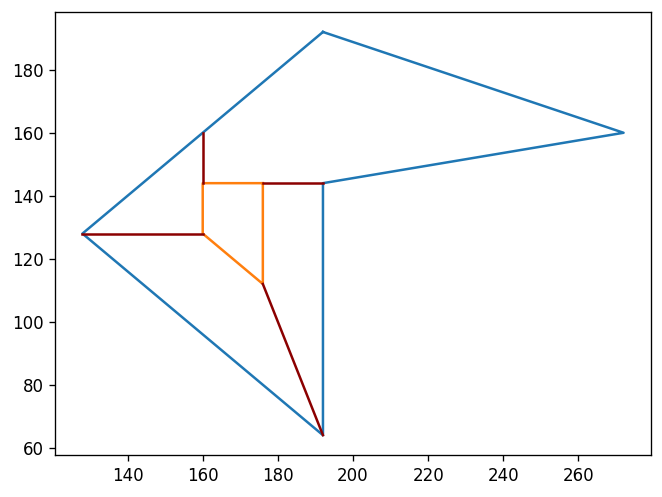

In [42]:
#plotting the new edges
polygon_plt()

for new in newedges:
    xs = [new[0].pt1.coordinate[0], new[0].pt2.coordinate[0]]
    ys = [new[0].pt1.coordinate[1], new[0].pt2.coordinate[1]]
    plt.plot(xs, ys, c='darkred')

plt.gcf().set_dpi(120)

plt.show()

In [43]:
#a function that returns the polygons that are on either side of a half-edge inserted by the algorithm
def get_polygons_adj_half_edge(half_edges, polygons):
    r_out, r_in = half_edges

    cvex1 = None
    cvex2 = None
    
    skip1 = False
    skip2 = False

    #if one of the edges occurs in a previously found polygon, we can skip that side
    for polygon in polygons:
        if r_out in polygon:
            skip1 = True
        if r_in in polygon:
            skip2 = True

    if not skip1:
        cvex1 = []

        cur = r_out
        prev = None

        #walk along the boundary of the polygon until it reaches itself
        while cur not in cvex1:
            # print("attempting to find cvex1 with ", cur)
            cvex1.append(cur)
            prev = cur
            cur = next(cur)

        # cvex1.append(cur)

    if not skip2:
        cvex2 = []

        r_in_out = next(r_in)
        cur = r_in_out
        prev = None

        while cur not in cvex2:
            # print("attempting to find cvex2 with ", cur)
            cvex2.append(cur)
            prev = cur
            cur = next(cur)

        # cvex2.append(cur)

    return cvex1, cvex2

##### Plot of one function result

4 4


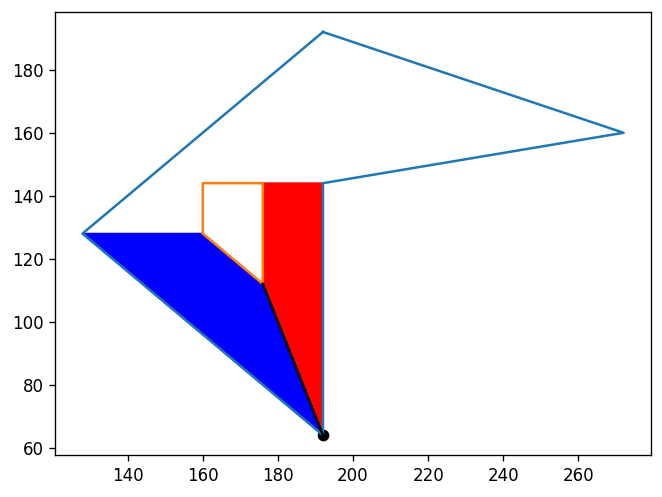

In [44]:
x = 1
c1, c2 = get_polygons_adj_half_edge(newedges[x], [])

print(len(c1), len(c2))

polygon_plt()
edge_plt(newedges[x][0])

xs = [e.pt1.coordinate[0] for e in c1]
ys = [e.pt1.coordinate[1] for e in c1]

plt.fill(xs, ys, c='red')

xs = [e.pt1.coordinate[0] for e in c2]
ys = [e.pt1.coordinate[1] for e in c2]

plt.fill(xs, ys, c='blue')

plt.gcf().set_dpi(120)
plt.show()

### Finding all convex polygons

In [45]:
polygons=[]
for i in range(len(newedges)):
    # print(i)
    pair = newedges[i]
    L, R = get_polygons_adj_half_edge(pair, polygons)
    if L is not None: polygons.append(L)
    if R is not None: polygons.append(R)

len(polygons)

4

##### Plotting the polygons

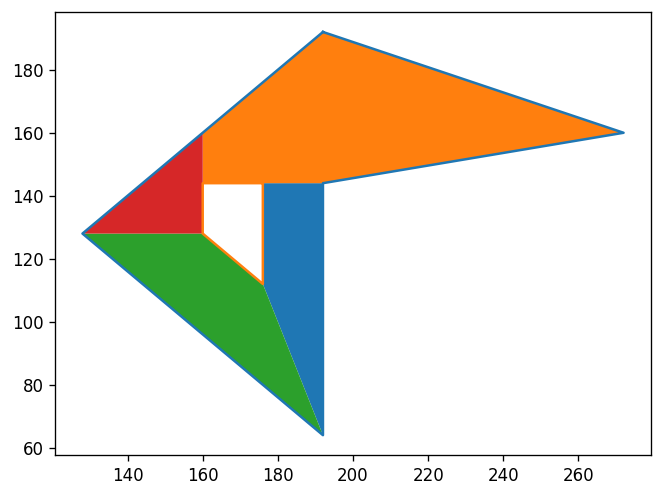

In [46]:
polygon_plt()

for polygon_edges in polygons:
    xs = [e.pt1.coordinate[0] for e in polygon_edges]
    ys = [e.pt1.coordinate[1] for e in polygon_edges]

    plt.fill(xs, ys)

plt.gcf().set_dpi(120)

# if some neighbouring polygons have the same colour it is because of the random colour assignment in pyplot

# Printing JSON

In [47]:
#polygons_to_write = []
#for pp in poly.holes:
#    print(pp.points)
#polygons_to_write = poly.holes #I hope you can make a list with all polygons and add those in the parameter "polygons_to_write"
#print(polygons_to_write)
#print(polygons)
#Name variables for dictionary
filename = path_to_testfile
print(filename)
leftbound = ''.join(filename).rindex('/')
rightbound = ''.join(filename).rindex('i')
#print(filename[leftbound+1:])
#print(filename[:rightbound])
print(filename[leftbound+1:rightbound-1])
instance = filename[leftbound+1:rightbound-1]
typename = "CGSHOP2023_Solution"

from decimal import Decimal

def to_float(d):
    d = Decimal(str(d)) #cast as string for proper fraction
    nom, den = d.as_integer_ratio()
    if den==1:
        #print(d)
        return d
    else:
        #print(nom, den)
        dict = {"num": nom, "den": den}
        return dict

def frac_to_dict(f):
    #print(f.numerator, f.denominator)
    dict = {"num": f.numerator, "den": f.denominator}
    return dict

lists = polygons
listsfin= []
listsdict = []

for item in lists:
    #print(item)
    for el in item:
        #print(el, el.pt1, el.pt2, el.pt1.coordinate, el.pt1.coordinate[0], el.pt1.coordinate[1])
        xc = el.pt1.coordinate[0]
        yc = el.pt1.coordinate[1]
        if(isinstance(xc, float)):
            xc = to_float(xc)
        if(type(xc) == Fraction):
            #print("Fraction")
            xc = frac_to_dict(xc)
        if(isinstance(yc, float)):
            yc = to_float(yc)
        if(type(yc) == Fraction):
            #print("Fraction")
            yc = frac_to_dict(yc)
        dictxy = {"x": xc, "y": yc}
        #print(dictxy)
        listsdict.append(dictxy)
    #print("NEW")
    listsfin.append(listsdict)
    #print(listsfin)
    listsdict = []

finaldict = {
    "type": typename,
    "instance": instance,
    "polygons": listsfin
}
#print(finaldict)
json_object = json.dumps(finaldict, indent=4)
with open("sol_"+instance+".json", "w") as outfile:
    outfile.write(json_object)

print("Created a json output file called:", "sol_"+instance+".json\n" , "for instance", instance)#,"\n", "with the following contents:\n", finaldict)
print("\nPlease use the polygons_to_write field to fill in all polygons that should be in the json file, this is now placeholded with the original holes")
        

./instances-2IMA15/instances-2IMA15/example_instance1.instance.json
example_instance1
Created a json output file called: sol_example_instance1.json
 for instance example_instance1

Please use the polygons_to_write field to fill in all polygons that should be in the json file, this is now placeholded with the original holes
